### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

--2022-01-29 16:33:18--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.171.162
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.171.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  64.6MB/s    in 1.9s    

2022-01-29 16:33:21 (64.6 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

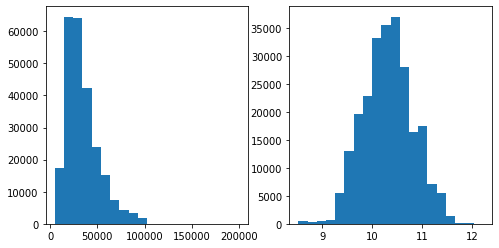

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);


In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
98818,69505390,PMLD Teachers Required in Lambeth,"We are currently seeking qualified, dedicated ...",Lambeth,Lambeth,full_time,contract,Capita Education,Teaching Jobs,120 - 140 per day,31200,jobs.newstatesman.com,10.348206
72507,68847273,IT Technical Helpdesk Agent (CCNA / Servers),IT Technical Helpdesk Agent (CCNA / Servers) *...,"London,West London,Wembley,Uxbridge,Slough,Hay...",London,NaN,permanent,TRS Consulting Ltd,IT Jobs,22K - 25K + Benefits,23500,londonjobs.co.uk,10.064798
36933,68285824,Account Executive Healthcare PR,A thriving Healthcare PR team at this global a...,London,London,NaN,permanent,Fresh Connect Limited,Healthcare & Nursing Jobs,22k - 26k pa,24000,emedcareers.com,10.085851


In [6]:
import nltk

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
def process_tokens(sentence):
  return ' '.join(tokenizer.tokenize(str(sentence).lower()))
data[['FullDescription', 'Title']].fillna('NA', inplace=True)
data['FullDescriptionTokenized'] = data['FullDescription'].apply(process_tokens)
data['TitleTokenized'] = data['Title'].apply(process_tokens)
data[['FullDescription', 'Title']] = data[['FullDescriptionTokenized', 'TitleTokenized']]
data.drop(['FullDescriptionTokenized', 'TitleTokenized'], axis=1, inplace=True)

/tmp/ipykernel_11/3972121404.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['FullDescription', 'Title']].fillna('NA', inplace=True)


In [7]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [8]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(decode_error='ignore', lowercase=False, min_df=10)
count_vect.fit(data_train.FullDescription + ' ' + data_train.Title)

CountVectorizer(decode_error='ignore', lowercase=False, min_df=10)

In [34]:
import torch
import tqdm

BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, word_dropout=0, device=DEVICE):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = count_vect.transform(data.Title).todense()
    batch["FullDescription"] = count_vect.transform(data.FullDescription).todense()
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=DEVICE, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [35]:
#Basic version

import torch.nn as nn
import torch.functional as F


class SalaryPredictorWithEmbeddings(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=32):
        super().__init__()
        self.title_embeddings = nn.Embedding(n_tokens, hid_size)
        self.title_conv = nn.Conv1d(hid_size, 10, 3)
        self.description_embeddings = nn.Embedding(n_tokens, hid_size)
        self.description_conv = nn.Conv1d(hid_size, 5, 3)
        self.cat_features_embeddings = nn.Linear(n_cat_features, 5, False)
        self.fc = nn.Linear(20, 1)
        
    def forward(self, batch):
        title = self.title_embeddings(batch['Title'])
        title = self.title_conv(title.permute(0,2,1))
        title = title.max(dim=2)[0]
        description = self.description_embeddings(batch['FullDescription'])
        description = self.description_conv(description.permute(0,2,1))
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

In [36]:
basic_model = SalaryPredictorWithEmbeddings().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(basic_model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    basic_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = basic_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(basic_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.25013
Mean absolute error: 0.40050
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.24111
Mean absolute error: 0.39435
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.23680
Mean absolute error: 0.39072
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.23346
Mean absolute error: 0.38805
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.23071
Mean absolute error: 0.38602
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.22857
Mean absolute error: 0.38361
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.22602
Mean absolute error: 0.38222
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.22329
Mean absolute error: 0.37922
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.22069
Mean absolute error: 0.37706
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.21824
Mean absolute error: 0.37472


In [12]:
import gensim.downloader 
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")

[=========-----------------------------------------] 18.3% 23.4/128.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.4% 78.6/128.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 128.1/128.1MB downloaded


In [37]:
def vectorize_sum(sentence):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    features = []
    
    for word in sentence.split():
      if word in embeddings.vocab:
        features.append(embeddings.get_vector(word))
    features = np.array(features, dtype='float64')
    return features

def pad_sentence_sequence(sentence_seq):
    max_len = 0
    vectorized_sentences = []
    for sentence in sentence_seq:
        vectorized_sentence = vectorize_sum(sentence)
        if vectorized_sentence.size:
            vectorized_sentences.append(vectorized_sentence)
            max_len = max(max_len, vectorized_sentence.shape[0])
        else:
            vectorized_sentences.append(np.zeros((1, embeddings.vector_size)))
    
    max_len = max(3, max_len)

    padded_vectors = []
    for i, vectorized_sentence in enumerate(vectorized_sentences):
        padded_vectors.append(np.pad(vectorized_sentence, ((0, max_len - vectorized_sentence.shape[0]), (0, 0))))
    return padded_vectors


def make_batch(data, word_dropout=0, device=DEVICE):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = pad_sentence_sequence(data.Title.values)
    batch["FullDescription"] = pad_sentence_sequence(data.FullDescription.values)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.float)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.float)
    return batch_tensors

In [38]:
#

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv = nn.Conv1d(hid_size, 10, 3)
        self.description_conv = nn.Conv1d(hid_size, 5, 3)
        self.cat_features_embeddings = nn.Linear(n_cat_features, 5, False)
        self.fc = nn.Linear(20, 1)
        
    def forward(self, batch):
        title = batch['Title']
        title = self.title_conv(title.permute(0,2,1))
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description = self.description_conv(description.permute(0,2,1))
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

In [39]:
preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(preembedded_model, data_val)


epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.17048
Mean absolute error: 0.32305
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14850
Mean absolute error: 0.29594
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13672
Mean absolute error: 0.28182
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12758
Mean absolute error: 0.27119
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12034
Mean absolute error: 0.26306
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11537
Mean absolute error: 0.25683
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11170
Mean absolute error: 0.25241
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10921
Mean absolute error: 0.24978
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10696
Mean absolute error: 0.24620
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10606
Mean absolute error: 0.24451


In [ ]:
del basic_model

In [48]:
### adding padding not to loose time dims

BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv = nn.Conv1d(hid_size, 5, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 5, False)
        self.fc = nn.Linear(20, 1)

    def forward(self, batch):
        title = batch['Title']
        title = self.title_conv(title.permute(0,2,1))
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description = self.description_conv(description.permute(0,2,1))
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.16372
Mean absolute error: 0.31377
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13872
Mean absolute error: 0.28578
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12513
Mean absolute error: 0.26667
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12074
Mean absolute error: 0.26045
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11385
Mean absolute error: 0.25630
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11188
Mean absolute error: 0.25034
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10595
Mean absolute error: 0.24529
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10363
Mean absolute error: 0.24222
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10192
Mean absolute error: 0.23960
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10045
Mean absolute error: 0.23844


In [49]:
#trying parallel convs
BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv1 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.title_conv2 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv1 = nn.Conv1d(hid_size, 5, 3, padding='same')
        self.description_conv2 = nn.Conv1d(hid_size, 5, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 5, False)
        self.fc = nn.Linear(35, 1)

    def forward(self, batch):
        title = batch['Title']
        title1 = self.title_conv1(title.permute(0,2,1))
        title2 = self.title_conv2(title.permute(0,2,1))
        title = torch.cat([title1, title2], dim=1)
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description1 = self.description_conv1(description.permute(0,2,1))
        description2 = self.description_conv2(description.permute(0,2,1))
        description = torch.cat([description1, description2], dim=1)
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.16545
Mean absolute error: 0.31470
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14462
Mean absolute error: 0.29011
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13219
Mean absolute error: 0.27649
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12290
Mean absolute error: 0.26596
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11811
Mean absolute error: 0.25801
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11148
Mean absolute error: 0.25055
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10699
Mean absolute error: 0.24528
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10262
Mean absolute error: 0.24164
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10098
Mean absolute error: 0.24051
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09783
Mean absolute error: 0.23549


In [52]:
#adding more features
BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv1 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.title_conv2 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.description_conv1 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv2 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 10, False)
        self.fc = nn.Linear(70, 1)

    def forward(self, batch):
        title = batch['Title']
        title1 = self.title_conv1(title.permute(0,2,1))
        title2 = self.title_conv2(title.permute(0,2,1))
        title = torch.cat([title1, title2], dim=1)
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description1 = self.description_conv1(description.permute(0,2,1))
        description2 = self.description_conv2(description.permute(0,2,1))
        description = torch.cat([description1, description2], dim=1)
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.16795
Mean absolute error: 0.31568
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14241
Mean absolute error: 0.28680
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12820
Mean absolute error: 0.27184
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11786
Mean absolute error: 0.25880
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11307
Mean absolute error: 0.25162
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10646
Mean absolute error: 0.24444
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10482
Mean absolute error: 0.24206
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10033
Mean absolute error: 0.23874
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09786
Mean absolute error: 0.23572
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09534
Mean absolute error: 0.23177


In [ ]:
#adding Dropout

BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv1 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.title_conv2 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.description_conv1 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv2 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 10, False)
        self.dropout_layer = nn.Dropout(p=0.01)
        self.fc = nn.Linear(70, 1)

    def forward(self, batch):
        title = batch['Title']
        title1 = self.title_conv1(title.permute(0,2,1))
        title2 = self.title_conv2(title.permute(0,2,1))
        title = torch.cat([title1, title2], dim=1)
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description1 = self.description_conv1(description.permute(0,2,1))
        description2 = self.description_conv2(description.permute(0,2,1))
        description = torch.cat([description1, description2], dim=1)
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        concatenated = torch.cat([title, description, cat_features], dim=1)
        concatenated = self.dropout_layer(concatenated)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.16733
Mean absolute error: 0.31416
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14455
Mean absolute error: 0.28897
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13180
Mean absolute error: 0.27803
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10985
Mean absolute error: 0.24912
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10796
Mean absolute error: 0.24620
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10442
Mean absolute error: 0.24206
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10025
Mean absolute error: 0.23811
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09831
Mean absolute error: 0.23570


In [ ]:
#adding Batchnorm

BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv1 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.title_conv2 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.description_conv1 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv2 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 10, False)
        self.cat_features_norm = nn.BatchNorm1d(10)
        self.dropout_layer = nn.Dropout(p=0.01)
        self.fc = nn.Linear(70, 1)

    def forward(self, batch):
        title = batch['Title']
        title1 = self.title_conv1(title.permute(0,2,1))
        title2 = self.title_conv2(title.permute(0,2,1))
        title = torch.cat([title1, title2], dim=1)
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description1 = self.description_conv1(description.permute(0,2,1))
        description2 = self.description_conv2(description.permute(0,2,1))
        description = torch.cat([description1, description2], dim=1)
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        cat_features = self.cat_features_norm(cat_features)
        concatenated = torch.cat([title, description, cat_features], dim=1)
        concatenated = self.dropout_layer(concatenated)
        output = self.fc(concatenated)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.15302
Mean absolute error: 0.29780
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13028
Mean absolute error: 0.27545
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11925
Mean absolute error: 0.26204
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11280
Mean absolute error: 0.25403
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10823
Mean absolute error: 0.24796
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10375
Mean absolute error: 0.24280
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10166
Mean absolute error: 0.24128
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09950
Mean absolute error: 0.23880
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09757
Mean absolute error: 0.23631
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09631
Mean absolute error: 0.23265


In [ ]:

#adding more FCs layers

BATCH_SIZE = 32
EPOCHS = 10

class SalaryPredictorPreEmbedded(nn.Module):
    def __init__(self, n_tokens=len(count_vect.vocabulary_), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=embeddings.vector_size):
        super().__init__()
        self.title_conv1 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.title_conv2 = nn.Conv1d(hid_size, 20, 3, padding='same')
        self.description_conv1 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.description_conv2 = nn.Conv1d(hid_size, 10, 3, padding='same')
        self.cat_features_embeddings = nn.Linear(n_cat_features, 10, False)
        self.cat_features_norm = nn.BatchNorm1d(10)
        self.dropout_layer = nn.Dropout(p=0.01)
        self.fc = nn.Linear(70, 20)
        self.fc_norm = nn.BatchNorm1d(20)
        self.fc_droput = nn.Dropout(p=0.01)
        self.fc2 = nn.Linear(20, 1)


    def forward(self, batch):
        title = batch['Title']
        title1 = self.title_conv1(title.permute(0,2,1))
        title2 = self.title_conv2(title.permute(0,2,1))
        title = torch.cat([title1, title2], dim=1)
        title = title.max(dim=2)[0]
        description = batch['FullDescription']
        description1 = self.description_conv1(description.permute(0,2,1))
        description2 = self.description_conv2(description.permute(0,2,1))
        description = torch.cat([description1, description2], dim=1)
        description = description.max(dim=2)[0]
        cat_features = self.cat_features_embeddings(batch['Categorical'])
        cat_features = self.cat_features_norm(cat_features)
        concatenated = torch.cat([title, description, cat_features], dim=1)
        concatenated = self.dropout_layer(concatenated)
        output = self.fc(concatenated)
        output = self.fc_norm(output)
        output = self.fc_droput(output)
        output = self.fc2(output)
        return output.squeeze(dim=1)

preembedded_model = SalaryPredictorPreEmbedded().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(preembedded_model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    preembedded_model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
    ):
        pred = preembedded_model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])/BATCH_SIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(preembedded_model, data_val)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11629
Mean absolute error: 0.26089
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10528
Mean absolute error: 0.24665
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09989
Mean absolute error: 0.23957
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09695
Mean absolute error: 0.23741
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09269
Mean absolute error: 0.23015
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09046
Mean absolute error: 0.22782
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08881
Mean absolute error: 0.22541
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08648
Mean absolute error: 0.22198
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08650
Mean absolute error: 0.22107
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08466
Mean absolute error: 0.21860


### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!